### **Importing Libraries**

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### **Contour Dataset Class**

In [ ]:
class ContourDataSet():

    def __init__(self, params):
        self.params = params
        self.setToolPathParams()
        self.preprocessData()

    def preprocessData(self):
        self.importData()
        self.calculateTimeStamps(display=True)
        self.get_features_targets()

    def importData(self):
        coordinates_data = pd.read_excel(self.params[COORDINATES_DATA_PATH])
        # Since z coordinate is same... (or) doesn't exist
        self.coordinates = coordinates_data.iloc[:, :2].values

        self.NUM_PARTICLES = self.coordinates.shape[0]

        # times_data = pd.read_excel('')
        # times = times_data.iloc[:, 1].values

        temperature_time_data = pd.read_excel(self.params[TEMPERATURE_TIME_DATA_PATH])
        self.temperatures = temperature_time_data.iloc[:, range(1, self.NUM_PARTICLES*2, 2)].values

        self.times = temperature_time_data.iloc[:, :1].values

        self.TIME_STEPS = self.times.shape[0]

        print('Data Shapes...')
        print(f'coordinates : {self.coordinates.shape}')
        print(f'times : {self.times.shape}')
        print(f'temperatures : {self.temperatures.shape}')

    def setToolPathParams(self):

        self.SPEED = self.params[SPEED]
        
        self.X_MIN = self.params[DIMENSIONS][0]
        self.X_MAX = self.params[DIMENSIONS][1]

        self.Y_MIN = self.params[DIMENSIONS][2]
        self.Y_MAX = self.params[DIMENSIONS][3]

        # Removed beacuse they reduce...
        # self.X_STEP_LEN = self.X_MAX - self.X_MIN
        # self.Y_STEP_LEN = self.Y_MAX - self.Y_MIN

        self.OFFSET = self.params[OFFSET]

    def calculateTimeStamps(self, display=False):

        X_STEP = self.X_MAX - self.X_MIN
        Y_STEP = self.Y_MAX - self.Y_MIN

        # Assuming starting point is top left...
        # Position - TimeStamp
        self.pos_ts = np.array([[self.X_MIN, self.Y_MAX, 0],
                                [self.X_MAX, self.Y_MAX, X_STEP/self.SPEED],
                                [self.X_MAX, self.Y_MIN, (X_STEP + Y_STEP)/self.SPEED],
                                [self.X_MIN, self.Y_MIN, (2*X_STEP + Y_STEP)/self.SPEED]])
        
        # Represents turn..
        i = 4
        
        while True:
            b = np.array([[0.0,0.0,0.0]])
            
            if (i % 4 == 0):
                Y_STEP = Y_STEP - self.OFFSET
                if (Y_STEP <= self.OFFSET):
                    break
                x = self.pos_ts[i-1][0]
                y = self.pos_ts[i-1][1] + Y_STEP
                t = self.pos_ts[i-1][2] + (Y_STEP/self.SPEED)
                
            elif (i % 4 == 1):
                X_STEP = X_STEP - self.OFFSET
                if (X_STEP <= self.OFFSET):
                    break
                x = self.pos_ts[i-1][0] + X_STEP
                y = self.pos_ts[i-1][1]
                t = self.pos_ts[i-1][2] + (X_STEP/self.SPEED)
                
            elif (i % 4 == 2):
                Y_STEP = Y_STEP - self.OFFSET
                if (Y_STEP <= self.OFFSET):
                    break
                x = self.pos_ts[i-1][0]
                y = self.pos_ts[i-1][1] - Y_STEP
                t = self.pos_ts[i-1][2] + (Y_STEP/self.SPEED)
                
            elif (i % 4 == 3):
                X_STEP = X_STEP - self.OFFSET
                if (X_STEP <= self.OFFSET):
                    break
                x = self.pos_ts[i-1][0] - X_STEP
                y = self.pos_ts[i-1][1]
                t = self.pos_ts[i-1][2] + (X_STEP/self.SPEED)
            
            self.pos_ts = np.vstack((self.pos_ts, 
                                                  np.array([[x, y, t]])))
            i = i+1

        if (display):
            plt.plot(self.pos_ts[:,0], self.pos_ts[:,1])
            plt.show()

    def rel_coordinates(self, xa, ya, t):

        if (t > self.pos_ts[-1][2]):
            return xa, ya, 1
        elif (t == self.pos_ts[-1][2]):
            return xa, ya, 0

        for i in range(self.pos_ts.shape[0]):

            if (t < self.pos_ts[i][2]):
                tt = t - self.pos_ts[i-1][2]
                dis = self.SPEED*tt
                
                # Going right
                if (self.pos_ts[i-1][1] == self.pos_ts[i][1] and self.pos_ts[i-1][0] < self.pos_ts[i][0]):
                    xt = self.pos_ts[i-1][0] + dis
                    yt = self.pos_ts[i-1][1]

                # Going down
                elif (self.pos_ts[i-1][0] == self.pos_ts[i][0] and self.pos_ts[i-1][1] > self.pos_ts[i][1]):
                    xt = self.pos_ts[i-1][0]
                    yt = self.pos_ts[i-1][1] - dis

                # Going left
                elif (self.pos_ts[i-1][1] == self.pos_ts[i][1] and self.pos_ts[i-1][0] > self.pos_ts[i][0]):
                    xt = self.pos_ts[i-1][0] - dis
                    yt = self.pos_ts[i-1][1]

                # Going up
                elif (self.pos_ts[i-1][0] == self.pos_ts[i][0] and self.pos_ts[i-1][1] < self.pos_ts[i][1]):
                    xt = self.pos_ts[i-1][0]
                    yt = self.pos_ts[i-1][1] + dis

                break

        return xa-xt, ya-yt, 0

    def get_features_targets(self):
        
        self.X = None

        for i in range(0, self.NUM_PARTICLES):
            a = self.times[:, :]
            b = self.temperatures[:, i:i+1]
            c = np.hstack((a, b))
            d = self.coordinates[i:i+1, :]
            e = np.array([d[0]]*self.TIME_STEPS)
            
            g = np.zeros(a.shape)

            f = np.hstack((e, e, g, c))

            for j in range(f.shape[0]):
                xa = f[j][0]
                ya = f[j][1]
                t = f[j][5]
                xr, yr, flag = self.rel_coordinates(xa, ya, t)
                f[j][0] = xr
                f[j][1] = yr
                f[j][4] = flag

            if self.X is None:
                self.X = f
            else:
                self.X = np.vstack((self.X, f))

        self.y = self.X[:, -1:]
        self.X = self.X[:, :-1]

        print(f'X shape : {self.X.shape}')
        print(f'y shape : {self.y.shape}')

### **ZigZag Dataset Class**

In [ ]:
class ZigZagDataSet():

    def __init__(self, params):
        self.params = params
        self.setToolPathParams()
        self.preprocessData()
        self.plotPattern()

    def preprocessData(self):
        self.importData()
        self.get_features_targets()

    def importData(self):
        coordinates_data = pd.read_excel(self.params[COORDINATES_DATA_PATH])
        # Since z coordinate is same... (or) doesn't exist
        self.coordinates = coordinates_data.iloc[:, :2].values

        self.NUM_PARTICLES = self.coordinates.shape[0]

        # times_data = pd.read_excel('')
        # times = times_data.iloc[:, 1].values

        temperature_time_data = pd.read_excel(self.params[TEMPERATURE_TIME_DATA_PATH])
        self.temperatures = temperature_time_data.iloc[:, range(1, self.NUM_PARTICLES*2, 2)].values

        self.times = temperature_time_data.iloc[:, :1].values

        self.TIME_STEPS = self.times.shape[0]

        print('Data Shapes...')
        print(f'coordinates : {self.coordinates.shape}')
        print(f'times : {self.times.shape}')
        print(f'temperatures : {self.temperatures.shape}')

    def setToolPathParams(self):

        self.SPEED = self.params[SPEED]
        
        self.X_MIN = self.params[DIMENSIONS][0]
        self.X_MAX = self.params[DIMENSIONS][1]

        self.Y_MIN = self.params[DIMENSIONS][2]
        self.Y_MAX = self.params[DIMENSIONS][3]

        self.START_DIR = self.params[DIRECTION]

        if (self.params[DIRECTION] == 'horizontal'):
            self.X_STEP_LEN = self.X_MAX - self.X_MIN
            self.Y_STEP_LEN = self.params[STEP_LENGTH][1]
            self.TOTAL_Y_STEPS = (self.Y_MAX - self.Y_MIN) / self.Y_STEP_LEN
            self.TOTAL_X_STEPS = self.TOTAL_Y_STEPS + 1

        elif (self.params[DIRECTION] == 'vertical'):
            self.X_STEP_LEN = self.params[STEP_LENGTH][0]
            self.Y_STEP_LEN = self.Y_MAX - self.Y_MIN
            self.TOTAL_X_STEPS = (self.X_MAX - self.X_MIN) / self.X_STEP_LEN
            self.TOTAL_Y_STEPS = self.TOTAL_X_STEPS + 1

        if (self.params[START_POS] == 'top-left'):
            self.X_DIR = +1
            self.Y_DIR = -1

        elif (self.params[START_POS] == 'top-right'):
            self.X_DIR = -1
            self.Y_DIR = -1

        elif (self.params[START_POS] == 'bottom-left'):
            self.X_DIR = +1
            self.Y_DIR = +1

        elif (self.params[START_POS] == 'bottom-right'):
            self.X_DIR = -1
            self.Y_DIR = +1   

        self.TOTAL_DIS = self.TOTAL_X_STEPS * self.X_STEP_LEN + self.TOTAL_Y_STEPS * self.Y_STEP_LEN

        self.TOTAL_PATTERN_TIME = self.TOTAL_DIS / self.SPEED

        self.X_STEP_TIME = self.X_STEP_LEN / self.SPEED
        self.Y_STEP_TIME = self.Y_STEP_LEN / self.SPEED

        self.STEP_TIME = self.X_STEP_TIME + self.Y_STEP_TIME

    def rel_coordinates(self, xa, ya, t):

        # 1 represents that deposition is completed
        if (t > self.TOTAL_PATTERN_TIME):
            return xa, ya, 1

        complete_steps = math.floor(t/self.STEP_TIME)
        tt = t - self.STEP_TIME*complete_steps

        if (self.START_DIR == 'horizontal'):
            
            if (tt >= self.X_STEP_TIME):
                xx = self.X_STEP_LEN
                yy = (tt -self.X_STEP_TIME)*self.SPEED
            else:
                xx = tt*self.SPEED
                yy = 0

            if (self.X_DIR == 1):
                if (complete_steps % 2 == 0):
                    xt = self.X_MIN + xx
                elif (complete_steps % 2 == 1):
                    xt = self.X_MAX - xx
            elif (self.X_DIR == -1):
                if (complete_steps % 2 == 1):
                    xt = self.X_MIN + xx
                elif (complete_steps % 2 == 0):
                    xt = self.X_MAX - xx

            if (self.Y_DIR == 1):
                yt = self.Y_MIN + complete_steps*(self.Y_STEP_LEN) + yy
            elif (self.Y_DIR == -1):
                yt = self.Y_MAX - complete_steps*(self.Y_STEP_LEN) - yy

        elif (self.START_DIR == 'vertical'):
            
            if (tt >= self.Y_STEP_TIME):
                yy = self.Y_STEP_LEN
                xx = (tt -self.Y_STEP_TIME)*self.SPEED
            else:
                yy = tt*self.SPEED
                xx = 0

            if (self.Y_DIR == 1):
                if (complete_steps % 2 == 0):
                    yt = self.Y_MIN + yy
                elif (complete_steps % 2 == 1):
                    yt = self.Y_MAX - yy
            elif (self.Y_DIR == -1):
                if (complete_steps % 2 == 1):
                    yt = self.Y_MIN + yy
                elif (complete_steps % 2 == 0):
                    yt = self.Y_MAX - yy

            if (self.X_DIR == 1):
                xt = self.X_MIN + complete_steps*(self.X_STEP_LEN) + xx
            elif (self.X_DIR == -1):
                xt = self.X_MAX - complete_steps*(self.X_STEP_LEN) - xx

        return xa-xt, ya-yt, 0

    def get_features_targets(self):
        
        self.X = None

        for i in range(0, self.NUM_PARTICLES):
            a = self.times[:, :]
            b = self.temperatures[:, i:i+1]
            c = np.hstack((a, b))
            d = self.coordinates[i:i+1, :]
            e = np.array([d[0]]*self.TIME_STEPS)
            
            g = np.zeros(a.shape)

            f = np.hstack((e, e, g, c))

            for j in range(f.shape[0]):
                xa = f[j][0]
                ya = f[j][1]
                t = f[j][5]
                xr, yr, flag = self.rel_coordinates(xa, ya, t)
                f[j][0] = xr
                f[j][1] = yr
                f[j][4] = flag

            if self.X is None:
                self.X = f
            else:
                self.X = np.vstack((self.X, f))

        self.y = self.X[:, -1:]
        self.X = self.X[:, :-1]

        print(f'X shape : {self.X.shape}')
        print(f'y shape : {self.y.shape}')

    def plotPattern(self):
        t = np.arange(0, self.TOTAL_PATTERN_TIME, 0.1)
        # t = np.arange(0, 100, 0.1)
        x = []
        y = []
        for tt in t:
            xx, yy, _ = self.rel_coordinates(0, 0, tt)
            x.append(-xx)
            y.append(-yy)

        plt.scatter(x, y, s=2)
        plt.show()

### **Generating DataSets**

#### **Input Parameters**

In [ ]:
COORDINATES_DATA_PATH      = 'coordinates_data_path'
TIME_DATA_PATH             = 'times_data_path'
TEMPERATURE_TIME_DATA_PATH = 'temperature_time_data_path'
DIMENSIONS                 = 'dimensions'
SPEED                      = 'speed'
STEP_LENGTH                = 'step_length'
START_POS                  = 'start_pos'
OFFSET                     = 'offset'
DIRECTION                  = 'direction'

#### **Contour Square**

Top Left Horizontal

Full Dim : 105.6 x 105.6

Half Dim : 52.8 x 52.8

Particles Dim : 51.15 x 51.15

In [ ]:
contour_norm_params = {
    COORDINATES_DATA_PATH : '/content/particles_coordinates.xlsx',
    TIME_DATA_PATH        : '',
    TEMPERATURE_TIME_DATA_PATH : '/content/square_contour.xlsx',
    DIMENSIONS            : [-52.8, 52.8, -52.8, 52.8],
    STEP_LENGTH           : [0, 0],
    SPEED                 : 10,
    START_POS             : 'top-left',
    OFFSET                : 3.3
}

#### **Contour Rectangle (Aspect Ratio)**

Top Left Horizontal

Full Dim : 211.2 x 52.8

Half Dim : 105.6 x 26.4

Particles Dim : 

In [ ]:
contour_ar_params = {
    COORDINATES_DATA_PATH : '/content/particle-coordinate_modified.xlsx',
    TIME_DATA_PATH        : '',
    TEMPERATURE_TIME_DATA_PATH : '/content/T-t-contour_modified.xlsx',
    DIMENSIONS            : [-105.6, 105.6, -26.4, 26.4],
    STEP_LENGTH           : [0, 0],
    SPEED                 : 10,
    START_POS             : 'top-left',
    OFFSET                : 3.3
}

#### **ZigZag Square**

Top Left Horizontal

Full Dim : 105.6 x 105.6

Half Dim : 52.8 x 52.8

Particles Dim : 51.15 x 51.15

In [ ]:
zigzag_norm_params = {
    COORDINATES_DATA_PATH : '/content/particles_coordinates.xlsx',
    TIME_DATA_PATH        : '',
    TEMPERATURE_TIME_DATA_PATH : '/content/square_zigzag.xlsx',
    DIMENSIONS            : [-52.8, 52.8, -52.8, 52.8],
    STEP_LENGTH           : [0, 3.3],
    SPEED                 : 10,
    START_POS             : 'top-left',
    DIRECTION             : 'horizontal',
    OFFSET                : 0
}

#### **ZigZag Rectangle (Aspect Ratio) Horizontal**

Top Left Horizontal

Full Dim : 211.2 x 52.8

Half Dim : 105.6 x 26.4

Particles Dim : 

In [ ]:
zigzag_ar_hor_params = {
    COORDINATES_DATA_PATH : '/content/particle-coordinate_modified.xlsx',
    TIME_DATA_PATH        : '',
    TEMPERATURE_TIME_DATA_PATH : '/content/T-t-zigzag-h_modified.xlsx',
    DIMENSIONS            : [-105.6, 105.6, -26.4, 26.4],
    STEP_LENGTH           : [0, 3.3],
    SPEED                 : 10,
    START_POS             : 'top-left',
    DIRECTION             : 'horizontal',
    OFFSET                : 0
}

#### **ZigZag Aspect Ratio Vertical**

Bottom Left Vertical

Full Dim : 211.2 x 52.8

Half Dim : 105.6 x 26.4

Particles Dim : 

In [ ]:
zigzag_ar_ver_params = {
    COORDINATES_DATA_PATH : '/content/particle-coordinate_modified.xlsx',
    TIME_DATA_PATH        : '',
    TEMPERATURE_TIME_DATA_PATH : '/content/T-t-zigzag-v_modified.xlsx',
    DIMENSIONS            : [-105.6, 105.6, -26.4, 26.4],
    STEP_LENGTH           : [3.3, 0],
    SPEED                 : 10,
    START_POS             : 'bottom-left',
    DIRECTION             : 'vertical',
    OFFSET                : 0
}

#### **DataSets**

Data Shapes...
coordinates : (1024, 2)
times : (1933, 1)
temperatures : (1933, 1024)


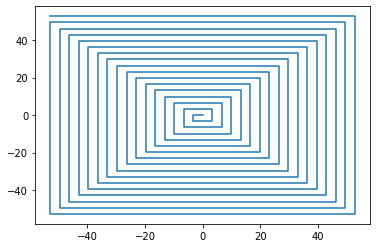

X shape : (1979392, 6)
y shape : (1979392, 1)


In [ ]:
contour_norm_ds = ContourDataSet(contour_norm_params)

Data Shapes...
coordinates : (1024, 2)
times : (1717, 1)
temperatures : (1717, 1024)


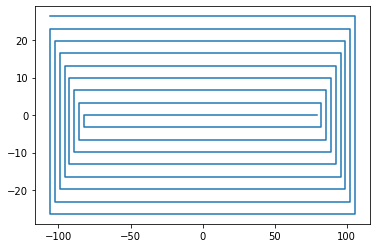

X shape : (1758208, 6)
y shape : (1758208, 1)


In [ ]:
contour_ar_ds = ContourDataSet(contour_ar_params)

Data Shapes...
coordinates : (1024, 2)
times : (1941, 1)
temperatures : (1941, 1024)
X shape : (1987584, 6)
y shape : (1987584, 1)


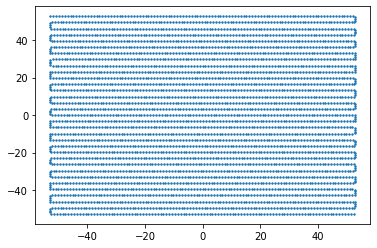

In [ ]:
zigzag_norm_ds = ZigZagDataSet(zigzag_norm_params)

Data Shapes...
coordinates : (1024, 2)
times : (1716, 1)
temperatures : (1716, 1024)
X shape : (1757184, 6)
y shape : (1757184, 1)


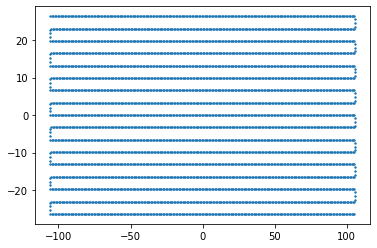

In [ ]:
zigzag_ar_hor_ds = ZigZagDataSet(zigzag_ar_hor_params)

Data Shapes...
coordinates : (1024, 2)
times : (1717, 1)
temperatures : (1717, 1024)
X shape : (1758208, 6)
y shape : (1758208, 1)


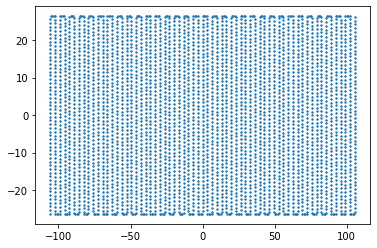

In [ ]:
zigzag_ar_ver_ds = ZigZagDataSet(zigzag_ar_ver_params)

### **Global Variables**

In [ ]:
SEED           = 42
LEARNING_RATE  = 1e-2
EPOCHS         = 200
BATCH_SIZE     = 256
TEST_SIZE      = 0.5

### **Splitting into Train and Test Data Sets**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
contour_norm_ds_split = train_test_split(
    contour_norm_ds.X,
    contour_norm_ds.y, 
    test_size=TEST_SIZE, 
    random_state=SEED
)

contour_ar_ds_split = train_test_split(
    contour_ar_ds.X,
    contour_ar_ds.y, 
    test_size=TEST_SIZE, 
    random_state=SEED
)

zigzag_norm_ds_split = train_test_split(
    zigzag_norm_ds.X,
    zigzag_norm_ds.y, 
    test_size=TEST_SIZE, 
    random_state=SEED
)

zigzag_ar_hor_ds_split = train_test_split(
    zigzag_ar_hor_ds.X,
    zigzag_ar_hor_ds.y, 
    test_size=TEST_SIZE, 
    random_state=SEED
)

zigzag_ar_ver_ds_split = train_test_split(
    zigzag_ar_ver_ds.X,
    zigzag_ar_ver_ds.y, 
    test_size=TEST_SIZE, 
    random_state=SEED
)

In [ ]:
# Order : X_train, X_test, y_train, y_test

X_train = np.vstack((
    contour_norm_ds_split[0],
    contour_ar_ds_split[0],
    zigzag_norm_ds_split[0],
    zigzag_ar_hor_ds_split[0],
    zigzag_ar_ver_ds_split[0]
))

X_test = np.vstack((
    contour_norm_ds_split[1],
    contour_ar_ds_split[1],
    zigzag_norm_ds_split[1],
    zigzag_ar_hor_ds_split[1],
    zigzag_ar_ver_ds_split[1] 
))

y_train = np.vstack((
    contour_norm_ds_split[2],
    contour_ar_ds_split[2],
    zigzag_norm_ds_split[2],
    zigzag_ar_hor_ds_split[2],
    zigzag_ar_ver_ds_split[2]
))

y_test = np.vstack((
    contour_norm_ds_split[3],
    contour_ar_ds_split[3],
    zigzag_norm_ds_split[3],
    zigzag_ar_hor_ds_split[3],
    zigzag_ar_ver_ds_split[3]
))

### **Standardisation**

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Neural Network**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [ ]:
class CustomDataset(Dataset):
    
    def __init__(self, x, y, transform=None, target_transform=None):
        self.inputs = x
        self.targets = y

    def __len__(self):
        return self.inputs.size()[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [ ]:
X__train = CustomDataset(X_train, y_train)
X__test = CustomDataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(
    dataset=X__train,
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=X__test, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential (
            nn.Linear(in_features=6, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in tqdm(range(EPOCHS)):

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):

        model.train()
        y_train_pred = model(X)
        loss = lossFunction(y_train_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_loss_values.append(train_loss)

    test_loss = 0

    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            y_test_pred = model(X)
            loss = lossFunction(y_test_pred, y)
            test_loss += loss.item()

        test_loss /= len(test_dataloader)
        test_loss_values.append(test_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

### **Loss Curves**

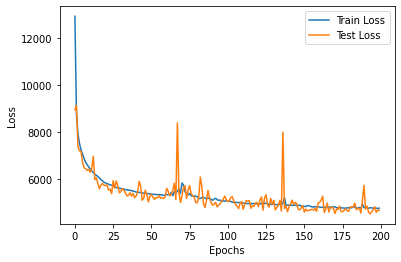

In [ ]:
plt.plot(range(EPOCHS), train_loss_values, label="Train Loss")
plt.plot(range(EPOCHS), test_loss_values, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.inference_mode():
    pred = model(X_test).numpy()

### **R^2 Value**

In [ ]:
from sklearn.metrics import explained_variance_score

In [ ]:
print(f"Neural Network Explained Variance: { explained_variance_score(y_test.numpy(), pred):.4f}")

Neural Network Explained Variance: 0.8646


### **Heat Maps**

In [ ]:
TT_data_ = pd.read_excel(TEMPERATURES_PATH)
TT_data = TT_data_.iloc[:, :].values

In [ ]:
T_T_z=TT_data
T_T_z.shape


(477, 512)

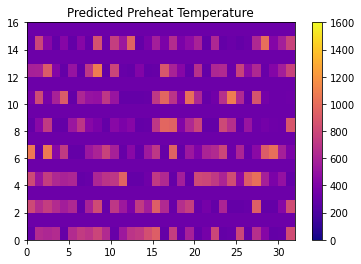

In [ ]:
Tpred_T_z = np.array(pred)
T_max = np.amax(T_T_z, axis=0)

T_ph_pred = [0]*len(T_max)

for i in np.arange(len(T_max)):
    for j in np.arange(len(T_T_z)):
        if T_T_z[j,i] == T_max[i] and T_T_z[j,i]>0:
            T_ph_pred[i] = Tpred_T_z[j-3]
            
T_ph_pred = np.array(T_ph_pred)

T_ph_pred = T_ph_pred.reshape(32, 16)
T_ph_pred = np.rot90(T_ph_pred, k = 1, axes = (0,1))

plt.pcolormesh(T_ph_pred, cmap = 'plasma',vmin = 0, vmax = 1600)
plt.title("Predicted Preheat Temperature")
plt.colorbar()
plt.show()

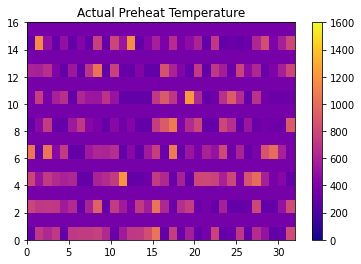

In [ ]:
Tpred_T_z = np.array(y_test)
T_max = np.amax(T_T_z, axis=0)

T_ph_pred = [0]*len(T_max)

for i in np.arange(len(T_max)):
    for j in np.arange(len(T_T_z)):
        if T_T_z[j,i] == T_max[i] and T_T_z[j,i]>0:
            T_ph_pred[i] = Tpred_T_z[j-3]
            
T_ph_pred = np.array(T_ph_pred)
T_ph_pred = T_ph_pred.reshape(32, 16)
T_ph_pred = np.rot90(T_ph_pred, k = 1, axes = (0,1))

plt.pcolormesh(T_ph_pred, cmap = 'plasma',vmin = 0, vmax = 1600)
plt.title("Actual Preheat Temperature")
plt.colorbar()
plt.show()